### Experimental

In [22]:
PDB_PATH = "/Users/amk19/Desktop/ChromatinVAE/Data/chromosome21_aligned.pdb"
AVERAGE_DISTANCE_PATH = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/average_distances.npy"
DISTANCE_OUTPUT = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/distance_map.png"
RADIUS_OF_GYRATION_OUTPUT = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/radius_of_gyration.png"
RADIUS_OF_GYRATION_DISTRIBUTION_OUTPUT = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/radius_of_gyration_distribution.png"
MODEL_PATH = "/Users/amk19/Desktop/ChromatinVAE/outputs/trained_vae_model.pt"
DISTRIBUTION_OUTPUT_1 = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/Distribution_of_Latent_Variable_1.png"
DISTRIBUTION_OUTPUT_2 = "/Users/amk19/Desktop/ChromatinVAE/outputs/Training_Set/Distribution_of_Latent_Variable_2.png"

### In Silico

In [16]:
PDB_PATH = "/scratch/amk19/ChromVAE/ChromVAE/Data/chromosome21_aligned.pdb"
MODEL_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/trained_vae_model.pt"
AVERAGE_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/average_distances.npy"
DISTANCE_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/distance_map.png"
RADIUS_OF_GYRATION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/radius_of_gyration.png"
RADIUS_OF_GYRATION_DISTRIBUTION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/radius_of_gyration_distribution.png"
DISTRIBUTION_OUTPUT_1 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/Distribution_of_Latent_Variable_1.png"
DISTRIBUTION_OUTPUT_2 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/Distribution_of_Latent_Variable_2.png"

In [11]:
PDB_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/generated_samples.pdb"
MODEL_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/trained_vae_model_stacked.pt"
AVERAGE_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/average_distances.npy"
DISTANCE_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/distance_map.png"
RADIUS_OF_GYRATION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/radius_of_gyration.png"
RADIUS_OF_GYRATION_DISTRIBUTION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/radius_of_gyration_distribution.png"
DISTRIBUTION_OUTPUT_1 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/Distribution_of_Latent_Variable_1.png"
DISTRIBUTION_OUTPUT_2 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples_stacked/Distribution_of_Latent_Variable_2.png"

# Model HyperParams

In [17]:
# Model hyperparameters (must match training configuration)
HIDDEN_DIM = 4096
LATENT_DIM = 2
BATCH_SIZE = 64

# Encode Data

In [ ]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from VAE.Simple_VAE import LGL_VAE
from DataLoader.Chromosome21PDBDataset import Chromosome21PDBDataset
from Utils.Utils import Utils
def encode_dataset(model, dataloader, device):    
    """
    Encode the entire dataset into latent space using the VAE encoder.
    
    Args:
        model: Trained VAE model
        dataloader: DataLoader containing the dataset
        device: Device to run inference on
    
    Returns:
        numpy array of shape (n_samples, latent_dim) containing latent representations
    """
    model.eval()
    latent_representations = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = batch.to(device)
            
            # Get latent representation (mu) from encoder
            # We use the mean of the latent distribution, not the sampled z
            x = batch.view(batch.shape[0], -1).float()
            hidden = model.encoder(x)
            mu = model.to_mu(hidden)
            
            # Store latent representations
            latent_representations.append(mu.cpu().numpy())
    
    # Concatenate all batches
    return np.concatenate(latent_representations, axis=0)

# Initialize Utils
utils = Utils()
print(f"Using device: {utils.device}")

# Load dataset with same preprocessing as training
print("Loading PDB dataset...")
dataset = Chromosome21PDBDataset(
    pdb_path=PDB_PATH,
    record_types=("ATOM",),
    center=True,  # Center coordinates (same as training)
    scale=1.0     # Don't scale (same as training)
)

print(f"Dataset loaded: {len(dataset)} models, {dataset.vector_length} coordinates per model")

# Create model with same architecture as training
print("Creating model...")
model = LGL_VAE(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, input_dim=dataset.vector_length)
model = model.to(utils.device)

# Load trained model weights
print(f"Loading trained model from {MODEL_PATH}...")
if not Path(MODEL_PATH).exists():
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=utils.device)
model.load_state_dict(checkpoint)
print("Model loaded successfully!")

# Split dataset into train/validation (same split as training)
print("Splitting dataset...")
total_size = len(dataset)
train_size = int(0.9 * total_size)
val_size = total_size - train_size

torch.manual_seed(0)  # Same seed as training
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Don't shuffle for consistent ordering
    collate_fn=Chromosome21PDBDataset.collate_batch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=Chromosome21PDBDataset.collate_batch
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Encode training data into latent space
print("Encoding training data into latent space...")
train_latent = encode_dataset(model, train_loader, utils.device)
print(f"Training latent representations shape: {train_latent.shape}")

# Encode validation data into latent space
print("Encoding validation data into latent space...")
val_latent = encode_dataset(model, val_loader, utils.device)
print(f"Validation latent representations shape: {val_latent.shape}")


Using device: cpu
Loading PDB dataset...


KeyboardInterrupt: 

# Plot Single Variable Distributions

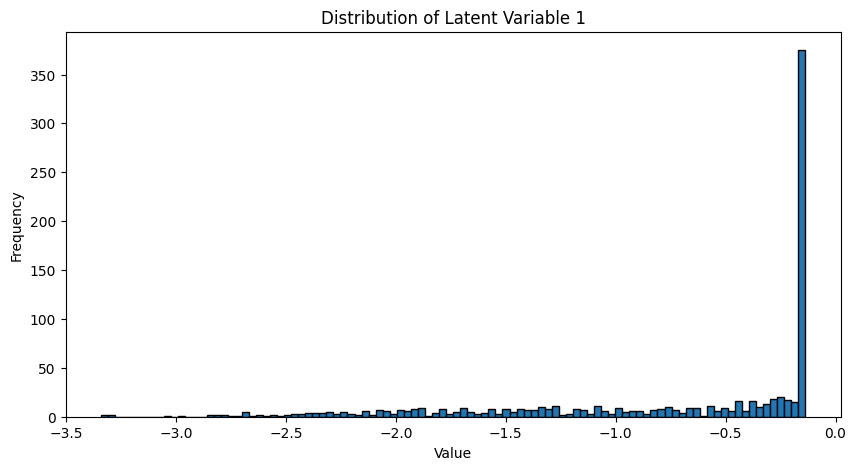

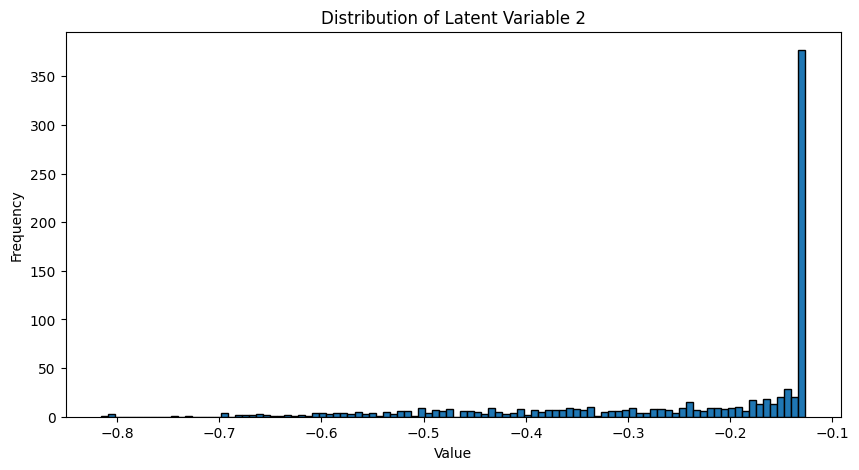

In [10]:
# Plot distribution of latent variable 1
plt.figure(figsize=(10, 5))
plt.hist(train_latent[:, 0], bins=100, edgecolor='black')
plt.title('Distribution of Latent Variable 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig(DISTRIBUTION_OUTPUT_1)
# Plot distribution of latent variable 1
plt.figure(figsize=(10, 5))
plt.hist(train_latent[:, 1], bins=100, edgecolor='black')
plt.title('Distribution of Latent Variable 2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig(DISTRIBUTION_OUTPUT_2)